### For this notebook you need to install tensorflow and keras
Recommended versions are: <BR>
-tensorflow 1.15.5 <BR>
-keras 2.3 <BR>
They are 40x times faster than tensorflow 2.8 <BR>
    
How to install: <BR>
`pip install tensorflow==1.15.5` <BR>
`pip install keras==2.3`    

In [1]:
import numpy as np
import os; 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from Environment import Environment, ACT_MODE, OBS_MODE
from Plotting import plotQ

In [2]:
class Q_function():  
    # stores the Q_function Q(s,a) = "future reward" as a dictionnary:
    # Q(s) = [ reward per action ]
    # either as a table (or function approximation, next notebook)    
    # stores the number of actions of the agent needed to add a new output 

    def __init__(self, env):       
        self.nactions = env.action_space.n
        self.f = {}
        
    def predict(self, s, a=None):
        if s not in self.f:
             self.f[s] = [0]*self.nactions       
        return self.f[s] if a is None else self.f[s][a]
    
    def update(self, s, a, y):
        self.f[s][a] = y


In [3]:
# **************************************************************************
# Q Approximation with Non-Linear approximators with Deep Neural Networks
# Requires tensorflow as the neural net is defined with it

class DQN_function():
    # stores the Q_function Q(s,a) = "future reward" but in fact Q(s) = [ f. reward per action ]
    # as function approximation with a Neural Network

    def __init__(self, env, params_qfunc=None):
        import tensorflow as tf
        from keras.models import Sequential
        if tf.version.VERSION[0] == '1':
            from keras.optimizers import Adam
            tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        else:
            from tf.keras.optimizers import Adam
            tf.logging.set_verbosity(tf.logging.ERROR)
            
        from keras.layers import Dense

        self.learning_rate = 0.001
        if(params_qfunc is not None):
            if("learning_rate" in params_qfunc):
                self.learning_rate = params_qfunc["learning_rate"]

        obs = env.reset() 
        if env.num_agents > 1:
            obs = obs[0]
        
        self.input_shape = obs.flatten().shape[0]

        print("DQN_function init obs_space.shape", env.observation_space.shape, "   used: ", self.input_shape)
        self.nactions = env.action_space.n

        self.model = Sequential()
        self.model.add(Dense(8, input_shape=(self.input_shape,), activation="relu"))
        self.model.add(Dense(16, activation="relu"))
        self.model.add(Dense(self.nactions, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(learning_rate=self.learning_rate))
        self.model.summary()

    def predict(self, s):
        s_flat = s.flatten()
        s_batch = np.reshape(s, [1, s_flat.shape[0]])
        return self.model.predict(s_batch)[0]

    def update(self, s, a, y):
        s_flat = s.flatten()
        s_batch = np.reshape(s, [1, s_flat.shape[0]])   
        q_values = self.model.predict(s_batch)[0]       
        q_values[a] = y
        q_values_batch = np.reshape(q_values, [1, self.nactions])
        self.model.fit(s_batch, q_values_batch, verbose=0)

    def update_batch(self, states, targets):
        self.model.train_on_batch(states, targets)

    def size(self):
        return 0

In [4]:
def print_info(n, i_episode, num_episodes, epsilon, sum_rew, Q=None, steps=None):
    if(i_episode == 0): 
        print(str(i_episode)," Starting learning running ",num_episodes," episodes plotting every ", int(n)," episodes")  
        return 
    if(epsilon < 0):
        print(i_episode,"   Mean Reward: ",sum_rew)
    else:
        str_steps = "" if steps is None else " Steps: "+str(steps)
        str_Q = "" if Q is None else " Q states: "+str(Q.size())
        print(i_episode, " epsilon: %.1f"%epsilon, "   Mean Reward: %.1f"%sum_rew, str_steps, str_Q)


In [5]:
def Q_learning(env, learning_rate=0.3, discount_factor=0.9, num_episodes=5000, num_episodes_end=4000, Q_function_class=Q_function):   
    np.random.seed()
    env.history = {"episode_rew":[], "episode_steps":[]}
    Q =  Q_function_class(env)
    mean_rew, mean_steps = 0, 0

    for i_episode in range(num_episodes):
        epsilon = max(1 - (1/num_episodes_end) * i_episode, 0)        
        state = env.reset()
        
        done = False
        sum_reward, steps = 0, 0
        while not done:
            q_values = Q.predict(state)
            if np.random.uniform() < epsilon:
                action = np.random.randint(env.nactions)   # explore
            else:
                action = np.argmax(q_values)  # exploit

            state_new, reward, done, _ = env.step(action)

            sum_reward += reward
            td_error = reward + discount_factor*np.max(Q.predict(state_new)) - q_values[action]
            td_target = q_values[action] + learning_rate*td_error
            Q.update(state,action,td_target)
            state = state_new
            steps += 1

        env.history["episode_rew"] += [sum_reward]
        env.history["episode_steps"] += [steps]
        mean_rew += sum_reward
        mean_steps += steps
        
        n = num_episodes / 50
        if (i_episode+1) % n == 0:
            print_info(n, i_episode, num_episodes, epsilon, mean_rew/n, steps=mean_steps/n, Q=Q)
            mean_rew, mean_steps = 0, 0

    env.close()
    return Q 

Default number of agents: 1
-allo-local-3rad-1ag Discrete Action Space with Discrete(4)


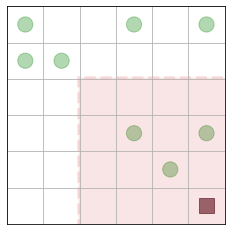

In [6]:
conf = {"name": "FinalGrid", "rows": 6, "cols": 6,
        "food": 8,
        "action_mode": ACT_MODE.ALLOCENTRIC,
        "obs_mode": OBS_MODE.LOCAL,
        "obs_radius": 3,
        "term_mode": "empty",
        "max_steps": 50,
        }

env = Environment(conf)

env.render()


In [7]:
params_qlearn = {"learning_rate":0.1, "discount_factor":0.95, "num_episodes":5000, "num_episodes_end":9000}
q_func = Q_learning(env, **params_qlearn, Q_function_class=DQN_function)

Using TensorFlow backend.


DQN_function init obs_space.shape (1, 7, 7)    used:  49
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 400       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 612
Trainable params: 612
Non-trainable params: 0
_________________________________________________________________
99  epsilon: 1.0    Mean Reward: 3.5  Steps: 50.0  Q states: 0
199  epsilon: 1.0    Mean Reward: 3.5  Steps: 50.0  Q states: 0
299  epsilon: 1.0    Mean Reward: 3.5  Steps: 49.97  Q states: 0
399  epsilon: 1.0    Mean Reward: 3.4  Steps: 49.98  Q states: 0
499  epsilon: 0.9    Mean Reward: 3.2  Steps: 50.0  Q states: 0
599  eps